<a href="https://colab.research.google.com/github/TEERAWATL/Saliency-Map-Expain-Object-detection-model/blob/main/Object_detection_by_torchvision_faster_RCNN_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [33]:
def load_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    if torch.cuda.is_available():
        model.cuda()

    return model

def detect_objects(image_path, model, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(image)

    with torch.no_grad():
        if torch.cuda.is_available():
            img_tensor = img_tensor.cuda()
        predictions = model([img_tensor])

    filtered_preds = []
    for idx, score in enumerate(predictions[0]['scores']):
        if score > threshold:
            filtered_preds.append({
                'bbox': predictions[0]['boxes'][idx].cpu().numpy(),
                'label': predictions[0]['labels'][idx].item(),
                'score': score.item()
            })

    return filtered_preds

def display_image_with_predictions(image_path, detections, class_names):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show the original image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    # Show the image with predicted bounding boxes
    ax[1].imshow(image)
    ax[1].set_title("Image with Predicted Locations")

    for detection in detections:

        bbox = detection['bbox']
        class_id = detection['label']  # Change this line to use the correct key
        class_name = class_names[class_id]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(bbox[0], bbox[1], class_name, fontsize=12, color='r', bbox=dict(facecolor='white', edgecolor='r', alpha=0.6))

    plt.show()

In [43]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving Modern_British_LED_Traffic_Light.jpg to Modern_British_LED_Traffic_Light (1).jpg


Detections:
Label: 10, Score: 1.00, BBox: [ 782.2379  478.8506 1360.1183 1944.681 ]


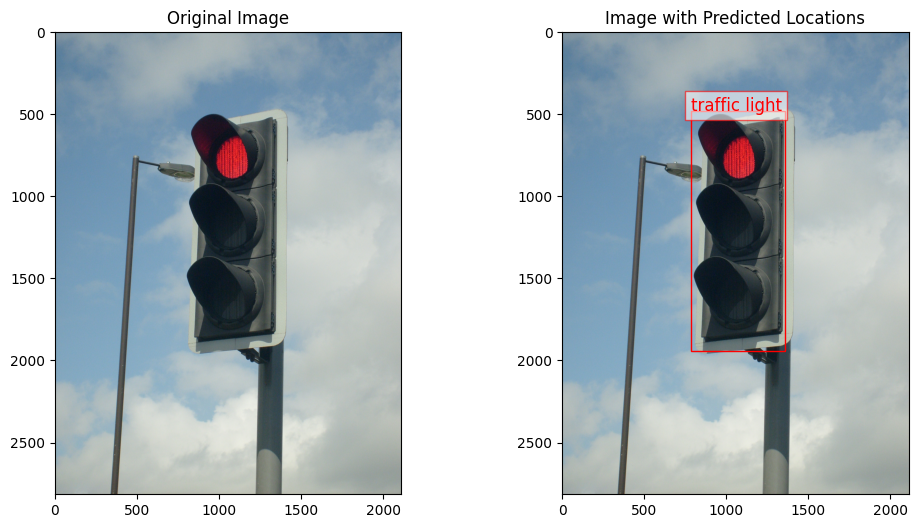

In [44]:
# Example usage
model = load_model()
detections = detect_objects(image_path, model, threshold=0.5)

print("Detections:")
for detection in detections:
    print("Label: {}, Score: {:.2f}, BBox: {}".format(detection['label'], detection['score'], detection['bbox']))

# print Out the result
class_names = ['a','person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck','boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench','bird', 'b', 'a', 'dog', 'cat', 'cow', 'elephant', 'bear', 'zebra', 'giraffe','backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis','snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard','surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon','bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog','pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table','toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave','oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors','teddy bear', 'hair drier', 'toothbrush']

  # Replace this with your actual class names list
display_image_with_predictions(image_path, detections, class_names)


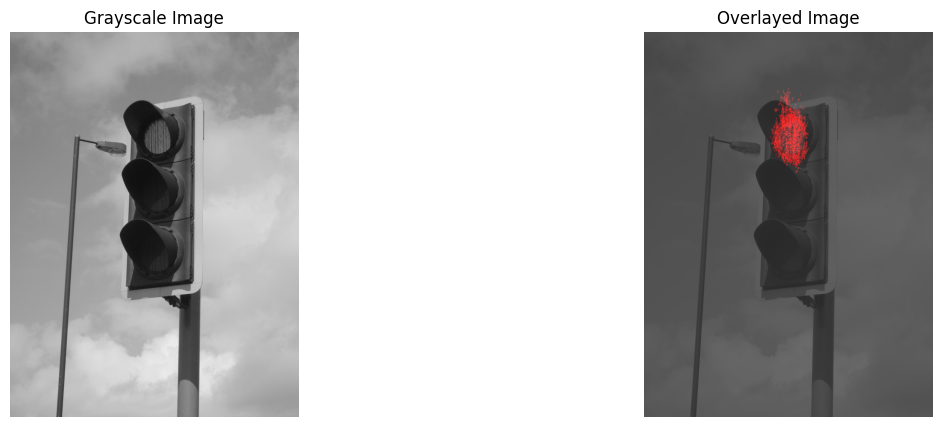

In [49]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

# Part 1: Preprocessing and model loading
transform = transforms.Compose([
    transforms.Resize((800, 1333)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def generate_saliency_map_torchvision(model, image_path):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    image_tensor.requires_grad_()

    output = model(image_tensor)
    max_score_idx = output[0]["scores"].argmax().item()
    score = output[0]["scores"][max_score_idx]

    score.backward()

    # Saliency map is the gradient of the score with respect to the input image
    saliency_map = image_tensor.grad.data.abs().numpy().sum(axis=1)

    return saliency_map

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Provide the path to your image
# image_path = "path/to/your/image.jpg"

# Part 2: Generate saliency map
saliency_map = generate_saliency_map_torchvision(model, image_path)

# Part 3: Post-processing
# Convert saliency_map back to a 2D array
saliency_map = saliency_map.squeeze()

# Normalize the saliency_map between 0 and 1
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# NEW: Apply a threshold to the saliency_map
threshold = 0.1
saliency_map[saliency_map < threshold] = 0

# Read the original image
original_image = Image.open(image_path)

# Convert the original image to grayscale
gray_image = original_image.convert('L')

# Convert gray_image to numpy array and normalize between 0 and 1
gray_image_np = np.array(gray_image) / 255

# NEW: Adjust the contrast of the grayscale image
contrast_scale = 0.3
gray_image_np = gray_image_np * contrast_scale + (1 - contrast_scale) * 0.2

# Create a 3-channel version of the gray image
gray_image_3ch = np.stack((gray_image_np, gray_image_np, gray_image_np), axis=-1)

# Resize the saliency map to the same shape as the grayscale image
saliency_map = zoom(saliency_map, (gray_image_np.shape[0] / saliency_map.shape[0], gray_image_np.shape[1] / saliency_map.shape[1]))

# Part 4: Display the results
# Overlay the saliency map on the gray image
overlayed_image = gray_image_3ch.copy()
overlayed_image[..., 0] += saliency_map * 1000 * (1 - gray_image_np) * 0.8  # Add saliency map to the red channel

# Display the grayscale image and overlayed image side by side using Matplotlib
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(gray_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Grayscale Image')

axs[1].imshow(overlayed_image)
axs[1].axis('off')
axs[1].set_title('Overlayed Image')

plt.show()
